# ***IMPORT DATASET***

In [1]:
# --- SEL 0.1: Unduh File ZIP dengan gdown dan Ekstrak ---
# Jalankan sel ini terlebih dahulu. Ini akan menyiapkan direktori, menginstal gdown,
# mengunduh file .zip dari Google Drive Anda, dan mengekstraknya.

import os
import zipfile

# Instal gdown jika belum terinstal
try:
    import gdown
except ImportError:
    print("Menginstal gdown...")
    !pip install gdown
    import gdown
print("gdown sudah siap.")

# Direktori proyek di Colab
PROJECT_DIR = '/content/cbr_narkotika_project'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR) # Pindah ke direktori proyek

# Buat struktur folder yang dibutuhkan
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
EVAL_DIR = os.path.join(DATA_DIR, 'eval')
RESULTS_DIR = os.path.join(DATA_DIR, 'results')
LOG_DIR = os.path.join(PROJECT_DIR, 'logs') # Untuk log pembersihan (opsional)

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(EVAL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print("Direktori proyek dan data telah disiapkan.")

# --- Detail File ZIP Anda di Google Drive ---
# File ID adalah bagian dari link Anda: https://drive.google.com/file/d/1SFLWcPuvggeTYbFMNrTAnzz0BxCisDM8/view?usp=sharing
file_id_zip = "1SFLWcPuvggeTYbFMNrTAnzz0BxCisDM8" # Ini adalah ID file ZIP Anda
output_zip_filename = "putusan_narkotika_data.zip"

print(f"\nMengunduh '{output_zip_filename}' dari Google Drive (ID: {file_id_zip})...")
try:
    # Menggunakan gdown.download untuk mengunduh file
    gdown.download(f"https://drive.google.com/uc?id={file_id_zip}", output_zip_filename, quiet=False)
    print(f"File '{output_zip_filename}' berhasil diunduh.")

    # Langkah: Mengekstrak isi file ZIP
    print(f"Mengekstrak '{output_zip_filename}' ke '{RAW_DATA_DIR}'...")
    with zipfile.ZipFile(output_zip_filename, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_DIR) # Ekstrak semua isi ke folder data/raw
    print(f"File '{output_zip_filename}' berhasil diekstrak.")

    # Verifikasi: Cek apakah file-file sudah ada di direktori
    print(f"\nDaftar awal file di '{RAW_DATA_DIR}':")
    for i, file in enumerate(os.listdir(RAW_DATA_DIR)):
        print(f"- {file}")
        if i >= 9: # Hanya tampilkan 10 file pertama untuk kerapian
            print("...(dan lebih banyak lagi)")
            break

    # Opsional: Hapus file ZIP setelah diekstrak untuk menghemat ruang di Colab
    os.remove(output_zip_filename)
    print(f"\nFile ZIP '{output_zip_filename}' dihapus setelah ekstraksi.")

except Exception as e:
    print(f"Terjadi error saat mengunduh atau mengekstrak file ZIP: {e}")
    print("Kemungkinan penyebab:")
    print("1. Izin berbagi file di Google Drive belum diatur ke 'Anyone with the link'.")
    print("2. ID file ZIP di kode salah.")
    print("3. File ZIP rusak.")

gdown sudah siap.
Direktori proyek dan data telah disiapkan.

Mengunduh 'putusan_narkotika_data.zip' dari Google Drive (ID: 1SFLWcPuvggeTYbFMNrTAnzz0BxCisDM8)...


Downloading...
From: https://drive.google.com/uc?id=1SFLWcPuvggeTYbFMNrTAnzz0BxCisDM8
To: /content/cbr_narkotika_project/putusan_narkotika_data.zip
100%|██████████| 4.35M/4.35M [00:00<00:00, 85.8MB/s]

File 'putusan_narkotika_data.zip' berhasil diunduh.
Mengekstrak 'putusan_narkotika_data.zip' ke '/content/cbr_narkotika_project/data/raw'...
File 'putusan_narkotika_data.zip' berhasil diekstrak.

Daftar awal file di '/content/cbr_narkotika_project/data/raw':
- putusan_316_k_mil_2017_20250628115754.pdf
- putusan_2008_k_pid.sus_2015_20250628115818.pdf
- putusan_3297_k_pid.sus_2018_20250628114834.pdf
- putusan_449_k_mil_2017_20250628115236.pdf
- putusan_533_k_pid.sus_2012_20250628115739.pdf
- putusan_1832_k_pid.sus_2014_20250628115150.pdf
- putusan_4297_k_pid.sus_2019_20250628115804.pdf
- putusan_1586_k_pid.sus_2012_20250628115758.pdf
- putusan_1243_k_pid.sus_2017_20250628115139.pdf
- putusan_2074_k_pid.sus_2015_20250628115729.pdf
...(dan lebih banyak lagi)

File ZIP 'putusan_narkotika_data.zip' dihapus setelah ekstraksi.


In [2]:
# --- SEL 0.2: Instalasi Library yang Dibutuhkan ---
# Jalankan sel ini untuk menginstal semua library yang diperlukan.
!pip install pandas numpy scikit-learn transformers beautifulsoup4 requests pdfminer.six openpyxl matplotlib

# Opsional: Jika Anda ingin menggunakan model bahasa Indonesia BERT (IndoBERT) dengan mudah
# !pip install sentence-transformers

print("Semua library yang dibutuhkan telah diinstal.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.2 MB/s eta 0:00:00
Semua library yang dibutuhkan telah diinstal.


# ***TAHAP 1 - MEMBANGUN CASE BASE***

In [3]:
# --- SEL 1: Konversi PDF ke TXT dan Pembersihan Teks ---
# Pastikan Anda telah menjalankan SEL 0.1 dan 0.2 sebelumnya.
import os
import re
from pdfminer.high_level import extract_text # Digunakan untuk PDF
import datetime

# Direktori yang sudah disiapkan di SEL 0.1
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'raw')
LOG_DIR = os.path.join(PROJECT_DIR, 'logs')
CLEANING_LOG_FILE = os.path.join(LOG_DIR, 'cleaning.log')

# Fungsi pembersihan teks
def clean_text(text):
    # Hapus baris kosong dan trim spasi
    lines = [line.strip() for line in text.split('\n') if line.strip()]
    text = '\n'.join(lines)

    # Hapus header/footer, nomor halaman, watermark. Ini sangat tergantung pola dokumen.
    # Anda mungkin perlu menyesuaikan regex ini berdasarkan file PDF Anda!
    cleaned_lines = []
    for line in lines:
        # Contoh: menghapus baris yang terlihat seperti nomor halaman atau teks footer/header singkat
        if not (re.match(r'^\s*hal\s+\d+\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*page\s+\d+\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*universitas\s+muhammadiyah\s+malang\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*fakultas\s+teknik\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*informatika\.umm\.ac\.id.*$', line, re.IGNORECASE) or
                re.match(r'^\s*informatika@umm\.ac\.id\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*est\.\s+\d+\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*umm\s*$', line, re.IGNORECASE) or
                re.match(r'^\s*lampiran\s+keputusan\s+rektor\s+\w+\s+\d+\s*$', line, re.IGNORECASE) or
                len(line.split()) < 3 # Baris sangat pendek
                ):
            cleaned_lines.append(line)
    text = ' '.join(cleaned_lines) # Gabungkan kembali menjadi satu string

    # Normalisasi spasi dan karakter
    text = text.lower() # Ubah ke huruf kecil
    text = re.sub(r'\s+', ' ', text).strip() # Normalisasi spasi berlebih menjadi satu spasi dan trim
    # Hapus karakter non-alfanumerik kecuali spasi, titik, koma. Sesuaikan jika ada karakter khusus lain yang penting.
    text = re.sub(r'[^a-z0-9\s.,]', '', text)
    return text

def process_and_clean_raw_files(raw_dir, log_file):
    processed_files_count = 0
    skipped_files_count = 0
    cleaning_logs = []
    files_in_raw_dir = os.listdir(raw_dir)

    for filename in files_in_raw_dir:
        file_path = os.path.join(raw_dir, filename)
        base_name, ext = os.path.splitext(filename)
        cleaned_txt_path = os.path.join(raw_dir, base_name + '.txt')

        raw_content = ""
        try:
            if ext.lower() == '.pdf':
                raw_content = extract_text(file_path)
                log_entry = f"[{datetime.datetime.now()}] Extracted text from PDF: {filename}"
            elif ext.lower() == '.txt':
                with open(file_path, 'r', encoding='utf-8') as f:
                    raw_content = f.read()
                log_entry = f"[{datetime.datetime.now()}] Read text from TXT: {filename}"
            else:
                cleaning_logs.append(f"[{datetime.datetime.now()}] SKIPPED: Unsupported file type for {filename}")
                skipped_files_count += 1
                continue

            cleaned_content = clean_text(raw_content)

            # Simpan teks yang sudah bersih (bisa overwrite atau simpan sebagai nama baru)
            with open(cleaned_txt_path, 'w', encoding='utf-8') as f:
                f.write(cleaned_content)

            cleaning_logs.append(f"{log_entry} -> Cleaned and saved to {base_name}.txt. Original length: {len(raw_content)}, Cleaned length: {len(cleaned_content)}")
            processed_files_count += 1

            # Hapus file PDF asli jika sudah berhasil dikonversi ke TXT
            if ext.lower() == '.pdf':
                os.remove(file_path)
                cleaning_logs.append(f"[{datetime.datetime.now()}] DELETED original PDF: {filename}")

        except Exception as e:
            cleaning_logs.append(f"[{datetime.datetime.now()}] ERROR processing {filename}: {e}")
            skipped_files_count += 1

    # Simpan log pembersihan
    with open(log_file, 'w', encoding='utf-8') as f:
        for entry in cleaning_logs:
            f.write(entry + '\n')
    print(f"Pembersihan selesai. Log disimpan di: {log_file}")
    print(f"Total file yang berhasil diproses: {processed_files_count}, Dilewati: {skipped_files_count}")

# Jalankan proses
process_and_clean_raw_files(RAW_DATA_DIR, CLEANING_LOG_FILE)

# Verifikasi file di data/raw (semua harus .txt)
print(f"\nDaftar file di '{RAW_DATA_DIR}' setelah pembersihan:")
for i, file in enumerate(os.listdir(RAW_DATA_DIR)):
    print(f"- {file}")
    if i >= 9:
        print("...(dan lebih banyak lagi)")
        break

Pembersihan selesai. Log disimpan di: /content/cbr_narkotika_project/logs/cleaning.log
Total file yang berhasil diproses: 30, Dilewati: 0

Daftar file di '/content/cbr_narkotika_project/data/raw' setelah pembersihan:
- putusan_1586_k_pid.sus_2012_20250628115758.txt
- putusan_746_k_pid.sus_2019_20250628115745.txt
- putusan_1117_k__pid.sus_2013_20250628115752.txt
- putusan_3541_k_pid.sus_2019_20250628115001.txt
- putusan_4297_k_pid.sus_2019_20250628115804.txt
- putusan_4231_k_pid.sus_2019_20250628115949.txt
- putusan_316_k_mil_2017_20250628115754.txt
- putusan_154_k_pid.sus_2018_20250628115256.txt
- putusan_1243_k_pid.sus_2017_20250628115139.txt
- putusan_1852_k_pid.sus_2017_20250628115245.txt
...(dan lebih banyak lagi)


# ***TAHAP 2 - CASE REPRESENTATION***

In [4]:
# --- SEL 2: Ekstraksi Metadata dan Fitur ---
# Pastikan Anda telah menjalankan SEL 0.1, 0.2, dan 1 sebelumnya.
import pandas as pd
import json
import os
import re

# Direktori yang sudah disiapkan di SEL 0.1
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'raw')
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')

# Fungsi untuk mengekstrak metadata dan konten kunci dari satu file teks putusan
def extract_case_features(file_path, case_id):
    with open(file_path, 'r', encoding='utf-8') as f:
        full_text = f.read()

    # --- EKSTRAKSI METADATA (SESUAIKAN DENGAN POLA DI DOKUMEN NARKOTIKA ANDA) ---
    # Contoh pola regex untuk kasus Narkotika. Anda mungkin perlu lebih spesifik!

    # Nomor Perkara (Contoh: Putusan Nomor 151 K/PID.SUS/2019)
    no_perkara_match = re.search(r'(?:nomor\s+putusan|nomor\s+perkara|no)\s*[:\s]*([a-zA-Z0-9\/\.\-]+)', full_text, re.IGNORECASE)
    no_perkara = no_perkara_match.group(1).strip() if no_perkara_match else 'Tidak Ditemukan'

    # Tanggal Putusan (Cari tanggal putusan MA final di bagian MENGADILI/MEMUTUSKAN)
    # Contoh: "...diputuskan dalam rapat musyawarah Majelis Hakim pada hari Selasa, tanggal 19 Maret 2019..."
    tanggal_match = re.search(r'tanggal\s+(\d{1,2}\s+\w+\s+\d{4})(?:\s+oleh|\s+tentang|\s+yang|\s+dan|\s+serta)?', full_text, re.IGNORECASE | re.DOTALL)
    tanggal = tanggal_match.group(1).strip() if tanggal_match else 'Tidak Ditemukan'

    # Jenis Perkara (Contoh: Pidana Khusus Narkotika dan Psikotropika)
    jenis_perkara_match = re.search(r'(pidana\s+khusus\s+narkotika\s+(?:dan|&)\s+psikotropika|narkotika|pidana\s+narkotika|pidana\s+militer)(?:\s+pada)?', full_text, re.IGNORECASE)
    jenis_perkara = jenis_perkara_match.group(0).strip() if jenis_perkara_match else 'Tidak Ditemukan'

    # Pasal yang Digunakan (Contoh: Pasal 112 ayat (1) UU No. 35 Tahun 2009 tentang Narkotika)
    pasal_matches = re.findall(r'(pasal\s+\d+\s*(?:ayat\s+\(\d+\))?\s*(?:huruf\s+\w)?\s*(?:uu\s+no\.\s+35\s+tahun\s+2009\s+tentang\s+narkotika|uu\s+narkotika|kuhp|uu\s+nomor\s+\d+\s+tahun\s+\d+)?)\s*(?:juncto|jo)?\s*(pasal\s+\d+\s*(?:ayat\s+\(\d+\))?\s*(?:huruf\s+\w)?\s*(?:uu\s+no\.\s+35\s+tahun\s+2009\s+tentang\s+narkotika|uu\s+narkotika|kuhp|uu\s+nomor\s+\d+\s+tahun\s+\d+)?)?', full_text, re.IGNORECASE)
    # Flatten list of tuples and remove duplicates
    all_pasal = []
    for match_tuple in pasal_matches:
        for p in match_tuple:
            if p: # Only add non-empty strings
                all_pasal.append(p.strip())
    pasal_digunakan = '; '.join(sorted(list(set(all_pasal)))) if all_pasal else 'Tidak Ditemukan'

    # Pihak-pihak (Jaksa Penuntut Umum, Terdakwa)
    jpu_match = re.search(r'(jaksa\s+penuntut\s+umum)\s+pada\s+kejaksaan\s+negeri\s+(.+?)(?:\s+tanggal|\s+tersebut|\s+telah|memutus\s+perkara|memeriksa\s+perkara|pada\s+pengadilan|\s+terdakwa|\n|$)', full_text, re.IGNORECASE | re.DOTALL)
    jpu = jpu_match.group(0).strip() if jpu_match else 'Tidak Ditemukan'

    # Menangani Terdakwa dengan berbagai format (Nama lengkap, Terdakwa:, Terdakwa I:, dll.)
    terdakwa_name = 'Tidak Ditemukan'
    terdakwa_match_patterns = [
        re.search(r'(?:nama\s+lengkap|nama)\s*[:\s]*(.+?)(?:pangkat\/nrp|tempat\s+lahir|umur|tanggal\s+lahir|jenis\s+kelamin|kewarganegaraan|tempat\s+tinggal|agama|pekerjaan|\n\s*\w+\s*:)', full_text, re.IGNORECASE | re.DOTALL),
        re.search(r'terdakwa\s*:\s*(.+?)(?:tempat\s+lahir|umur|tanggal\s+lahir|jenis\s+kelamin|kewarganegaraan|tempat\s+tinggal|agama|pekerjaan|\n\s*\w+\s*:)', full_text, re.IGNORECASE | re.DOTALL),
        re.search(r'terdakwa\s+(?:i|ii|iii)\.?\s*(.+?)(?:tempat\s+lahir|umur|tanggal\s+lahir|jenis\s+kelamin|kewarganegaraan|tempat\s+tinggal|agama|pekerjaan|\n\s*\w+\s*:)', full_text, re.IGNORECASE | re.DOTALL)
    ]
    for pattern in terdakwa_match_patterns:
        if pattern:
            terdakwa_name = pattern.group(1).strip().split('\n')[0].strip()
            break

    pihak_str = f"JPU: {jpu}, Terdakwa: {terdakwa_name}"


    # --- EKSTRAKSI KONTEN KUNCI ---
    # Ringkasan Fakta (biasanya di bagian 'fakta persidangan', 'fakta hukum', atau awal dakwaan)
    fakta_match = re.search(r'(?:fakta\s+persidangan|fakta\s+hukum|dakwaan\s+primair|bahwa\s+ia\s+terdakwa).*?((?:.|\n)*?)(?=pertimbangan\s+hukum|menimbang|mempertimbangkan|tuntutan\s+pidana|amar\s+lengkapnya)', full_text, re.IGNORECASE | re.DOTALL)
    ringkasan_fakta = fakta_match.group(1).strip() if fakta_match else full_text[:min(2000, len(full_text))] + '...' # Fallback

    # Argumen Hukum Utama (biasanya di bagian 'pertimbangan hukum', 'menimbang')
    argumen_match = re.search(r'(?:pertimbangan\s+hukum|menimbang).*?((?:.|\n)*?)(?=m e n g a d i l i|m e m u t u s k a n|memperhatikan)', full_text, re.IGNORECASE | re.DOTALL)
    argumen_hukum_utama = argumen_match.group(1).strip() if argumen_match else full_text[-min(2000, len(full_text)):] + '...' # Fallback

    # Amar Putusan (Bagian akhir putusan, setelah 'MENGADILI' atau 'MEMUTUSKAN')
    amar_putusan_match = re.search(r'(?:m e n g a d i l i|m e m u t u s k a n)((?:.|\n)*)(?:demikianlah\s+diputuskan|untuk\s+salinan|kepaniteraan\s+mahkamah\s+agung|\Z)', full_text, re.IGNORECASE | re.DOTALL)
    amar_putusan = amar_putusan_match.group(1).strip() if amar_putusan_match else 'Tidak Ditemukan'


    # --- FEATURE ENGINEERING ---
    word_count = len(full_text.split())

    return {
        "case_id": case_id,
        "filename": os.path.basename(file_path),
        "no_perkara": no_perkara,
        "tanggal": tanggal,
        "jenis_perkara": jenis_perkara,
        "pasal": pasal_digunakan,
        "pihak": pihak_str,
        "ringkasan_fakta": ringkasan_fakta,
        "argumen_hukum_utama": argumen_hukum_utama,
        "amar_putusan": amar_putusan, # Tambahkan amar putusan sebagai potensi solusi
        "text_full": full_text, # Simpan teks lengkap juga
        "word_count": word_count
    }

# Proses semua file TXT di direktori raw
cases_data = []
txt_files = [f for f in os.listdir(RAW_DATA_DIR) if f.endswith('.txt')]
txt_files.sort() # Urutkan untuk konsistensi case_id

print(f"Mengekstrak fitur dari {len(txt_files)} dokumen teks...")
for i, filename in enumerate(txt_files):
    file_path = os.path.join(RAW_DATA_DIR, filename)
    features = extract_case_features(file_path, i + 1)
    cases_data.append(features)

# Simpan ke CSV
df_cases = pd.DataFrame(cases_data)
df_cases.to_csv(os.path.join(PROCESSED_DATA_DIR, 'cases.csv'), index=False)
# df_cases.to_json(os.path.join(PROCESSED_DATA_DIR, 'cases.json'), orient='records', indent=4)

print(f"Data kasus dengan fitur berhasil disimpan ke {PROCESSED_DATA_DIR}/cases.csv")
print("Tahap 2 (Case Representation) selesai.")

# Tampilkan beberapa baris pertama dari DataFrame untuk verifikasi
print("\n--- Contoh data kasus yang diproses (5 baris pertama): ---")
print(df_cases.head())
print(f"\nTotal kasus diproses: {len(df_cases)}")
print("Kolom yang tersedia:", df_cases.columns.tolist())

Mengekstrak fitur dari 30 dokumen teks...
Data kasus dengan fitur berhasil disimpan ke /content/cbr_narkotika_project/data/processed/cases.csv
Tahap 2 (Case Representation) selesai.

--- Contoh data kasus yang diproses (5 baris pertama): ---
   case_id                                         filename  \
0        1  putusan_1117_k__pid.sus_2013_20250628115752.txt   
1        2   putusan_1243_k_pid.sus_2017_20250628115139.txt   
2        3   putusan_1378_k_pid.sus_2018_20250628115304.txt   
3        4   putusan_1496_k_pid.sus_2019_20250628115942.txt   
4        5   putusan_1500_k_pid.sus_2018_20250628115148.txt   

                                          no_perkara           tanggal  \
0                                                mor      21 juni 2012   
1  .1243kpid.sus2017putusannomor1243kpid.sus2017demi      9 maret 2016   
2                                                mor  4 september 2017   
3                                                mor  16 november 2017   
4        

# ***TAHAP 3 - CASE RETRIEVAL***

In [5]:
# --- SEL 3: Case Retrieval ---
# Pastikan Anda telah menjalankan SEL 0.1, 0.2, 1, dan 2 sebelumnya.
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import os
import re # Untuk fungsi clean_text_for_query

# Jika ingin menggunakan BERT (opsional):
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Direktori yang sudah disiapkan di SEL 0.1
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
EVAL_DIR = os.path.join(PROJECT_DIR, 'data', 'eval')

# Muat data kasus yang sudah diproses
df_cases = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'cases.csv'))
corpus = df_cases['text_full'].tolist() # Gunakan teks lengkap sebagai korpus untuk vektorisasi

# Inisialisasi Vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer(
    stop_words='english', # Anda bisa menambahkan stop_words bahasa Indonesia jika ada daftar
    min_df=5, # Abaikan istilah yang muncul di kurang dari 5 dokumen
    max_df=0.8, # Abaikan istilah yang muncul di lebih dari 80% dokumen
    max_features=10000 # Batasi jumlah fitur
)
tfidf_matrix = vectorizer_tfidf.fit_transform(corpus)
print(f"TF-IDF matrix created with shape: {tfidf_matrix.shape}")

# Inisialisasi Model BERT (IndoBERT) - Opsional, membutuhkan GPU untuk performa baik
tokenizer_bert = None
model_bert = None
bert_embeddings = None

print("\n--- Inisialisasi BERT (IndoBERT) (Opsional) ---")
try:
    # Set timeout untuk download model (opsional, jika sering error download)
    # os.environ['TRANSFORMERS_OFFLINE'] = '1' # Set ini jika Anda sudah punya model lokal
    # os.environ['HF_HOME'] = '/path/to/your/transformers/cache' # Atur path cache

    tokenizer_bert = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model_bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

    # Pindahkan model ke GPU jika tersedia
    if torch.cuda.is_available():
        model_bert.to('cuda')
        print("BERT model moved to GPU.")
    else:
        print("GPU not available, BERT model running on CPU (akan lebih lambat).")

    # Fungsi untuk mendapatkan embeddings BERT
    def get_bert_embeddings(texts, tokenizer, model, batch_size=16):
        model.eval() # Set model ke mode evaluasi
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
            # Pindahkan input ke GPU jika model di GPU
            if torch.cuda.is_available():
                inputs = {k: v.to('cuda') for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
            # Ambil mean pooling dari hidden states, pindahkan ke CPU dan konversi ke numpy
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
        return np.vstack(embeddings)

    print("Menghitung BERT embeddings untuk seluruh korpus. Ini mungkin memakan waktu...")
    bert_embeddings = get_bert_embeddings(corpus, tokenizer_bert, model_bert)
    print(f"BERT embeddings created with shape: {bert_embeddings.shape}")

except Exception as e:
    print(f"Gagal menginisialisasi atau mendapatkan BERT embeddings: {e}")
    print("Mungkin tidak ada GPU, masalah unduhan model, atau memori tidak cukup. Lanjutkan tanpa BERT.")
    tokenizer_bert = None
    model_bert = None
    bert_embeddings = None


# Fungsi pembersihan teks untuk query (sederhana) - Sama seperti di Tahap 1, tapi diulang agar fungsi berdiri sendiri
def clean_text_for_query(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-z0-9\s.,]', '', text)
    return text

# Fungsi Retrieval Utama
def retrieve(query: str, k: int = 5, df_cases=None, vectorizer_tfidf=None, tfidf_matrix=None,
             retrieval_type='tfidf', tokenizer_bert=None, model_bert=None, bert_embeddings=None):

    cleaned_query = clean_text_for_query(query)

    if retrieval_type == 'tfidf':
        if vectorizer_tfidf is None or tfidf_matrix is None:
            raise ValueError("TF-IDF vectorizer and matrix must be provided for TF-IDF retrieval.")
        query_vector = vectorizer_tfidf.transform([cleaned_query])
        similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    elif retrieval_type == 'bert':
        if tokenizer_bert is None or model_bert is None or bert_embeddings is None:
            raise ValueError("BERT tokenizer, model, and embeddings must be provided for BERT retrieval.")
        query_embedding = get_bert_embeddings([cleaned_query], tokenizer_bert, model_bert)[0] # [0] karena hanya 1 query
        similarities = cosine_similarity(query_embedding.reshape(1, -1), bert_embeddings).flatten()
    else:
        raise ValueError("Unsupported retrieval_type. Choose 'tfidf' or 'bert'.")

    # Ambil indeks top-k kasus teratas
    top_k_indices = similarities.argsort()[-k:][::-1] # Indeks dalam array numpy
    top_k_case_ids = df_cases.iloc[top_k_indices]['case_id'].tolist()
    top_k_similarities = similarities[top_k_indices].tolist()

    return top_k_case_ids, top_k_similarities

# Buat/muat file queries.json untuk pengujian awal
# Ini adalah contoh query, Anda bisa sesuaikan dengan query khas narkotika
queries_data_initial = [
    {"query_id": 1, "query_text": "Terdakwa memiliki dan menguasai sabu-sabu 1 gram tanpa izin", "ground_truth_case_id": [1, 5, 8]}, # Sesuaikan ground_truth_case_id
    {"query_id": 2, "query_text": "Kasus peredaran narkotika jenis ekstasi di tempat hiburan malam", "ground_truth_case_id": [2, 12, 15]},
    {"query_id": 3, "query_text": "Kurir ganja lintas provinsi dengan jumlah 10 kilogram", "ground_truth_case_id": [3, 10, 11]},
    {"query_id": 4, "query_text": "Penggunaan narkotika jenis psikotropika oleh mahasiswa", "ground_truth_case_id": [4, 18]},
    {"query_id": 5, "query_text": "Tindak pidana pencurian disertai penyalahgunaan narkotika", "ground_truth_case_id": [6, 7]}
]
with open(os.path.join(EVAL_DIR, 'queries.json'), 'w', encoding='utf-8') as f:
    json.dump(queries_data_initial, f, indent=4)
print(f"\nInitial queries saved to {EVAL_DIR}/queries.json")


# --- Contoh Penggunaan Fungsi Retrieval ---
print("\n--- Contoh Penggunaan Fungsi Retrieval (TF-IDF) ---")
test_query_tfidf = "Kasus kepemilikan narkotika jenis shabu 0.5 gram"
top_cases_tfidf, scores_tfidf = retrieve(
    test_query_tfidf, k=3, df_cases=df_cases, vectorizer_tfidf=vectorizer_tfidf,
    tfidf_matrix=tfidf_matrix, retrieval_type='tfidf'
)
print(f"Query: '{test_query_tfidf}'")
print(f"Top 3 cases (TF-IDF): {top_cases_tfidf} with similarities: {[f'{s:.4f}' for s in scores_tfidf]}")

if bert_embeddings is not None:
    print("\n--- Contoh Penggunaan Fungsi Retrieval (BERT) ---")
    test_query_bert = "Terdakwa pengedar narkoba jenis pil ekstasi"
    top_cases_bert, scores_bert = retrieve(
        test_query_bert, k=3, df_cases=df_cases, retrieval_type='bert',
        tokenizer_bert=tokenizer_bert, model_bert=model_bert, bert_embeddings=bert_embeddings
    )
    print(f"Query: '{test_query_bert}'")
    print(f"Top 3 cases (BERT): {top_cases_bert} with similarities: {[f'{s:.4f}' for s in scores_bert]}")

print("\nTahap 3 (Case Retrieval) selesai.")

TF-IDF matrix created with shape: (30, 758)

--- Inisialisasi BERT (IndoBERT) (Opsional) ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

GPU not available, BERT model running on CPU (akan lebih lambat).
Menghitung BERT embeddings untuk seluruh korpus. Ini mungkin memakan waktu...
BERT embeddings created with shape: (30, 768)

Initial queries saved to /content/cbr_narkotika_project/data/eval/queries.json

--- Contoh Penggunaan Fungsi Retrieval (TF-IDF) ---
Query: 'Kasus kepemilikan narkotika jenis shabu 0.5 gram'
Top 3 cases (TF-IDF): [13, 5, 11] with similarities: ['0.2142', '0.1490', '0.0811']

--- Contoh Penggunaan Fungsi Retrieval (BERT) ---
Query: 'Terdakwa pengedar narkoba jenis pil ekstasi'
Top 3 cases (BERT): [3, 4, 19] with similarities: ['0.3028', '0.3021', '0.2695']

Tahap 3 (Case Retrieval) selesai.


# ***TAHAP 4 - SOLUTION REUSE***

In [6]:
# --- SEL 4: Case/Solution Reuse ---
# Pastikan Anda telah menjalankan SEL 0.1, 0.2, 1, 2, dan 3 sebelumnya.
import pandas as pd
import json
import os

# Direktori yang sudah disiapkan di SEL 0.1
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data', 'results')
EVAL_DIR = os.path.join(PROJECT_DIR, 'data', 'eval') # Untuk memuat queries

# Muat data kasus yang sudah diproses
df_cases = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'cases.csv'))

# Fungsi untuk mengekstrak solusi dari kasus berdasarkan case_id
def extract_solution_from_case(case_id, df_cases):
    case = df_cases[df_cases['case_id'] == case_id]
    if not case.empty:
        # Kita akan menggunakan 'amar_putusan' sebagai solusi.
        # Jika amar putusan tidak ditemukan atau kosong, gunakan 'argumen_hukum_utama' sebagai fallback.
        solution = case.iloc[0]['amar_putusan']
        if solution == 'Tidak Ditemukan' or pd.isna(solution) or solution.strip() == '':
            solution = case.iloc[0]['argumen_hukum_utama']
        return solution
    return "Solusi tidak ditemukan."

# Fungsi prediksi outcome
def predict_outcome(query: str, k: int = 5, df_cases=None, vectorizer_tfidf=None, tfidf_matrix=None,
                    retrieval_type='tfidf', tokenizer_bert=None, model_bert=None, bert_embeddings=None):

    # Pastikan semua argumen yang diperlukan tersedia
    if df_cases is None:
        raise ValueError("df_cases must be provided.")
    if retrieval_type == 'tfidf' and (vectorizer_tfidf is None or tfidf_matrix is None):
        raise ValueError("TF-IDF vectorizer and matrix must be provided for TF-IDF retrieval.")
    if retrieval_type == 'bert' and (tokenizer_bert is None or model_bert is None or bert_embeddings is None):
        raise ValueError("BERT tokenizer, model, and embeddings must be provided for BERT retrieval.")

    # 1. Retrieve top-k cases
    top_k_case_ids, top_k_similarities = retrieve(
        query, k=k, df_cases=df_cases, vectorizer_tfidf=vectorizer_tfidf, tfidf_matrix=tfidf_matrix,
        retrieval_type=retrieval_type, tokenizer_bert=tokenizer_bert, model_bert=model_bert, bert_embeddings=bert_embeddings
    )

    if not top_k_case_ids:
        return "Tidak ada kasus serupa ditemukan.", []

    # 2. Ambil elemen putusan sebagai "solusi" dari kasus yang paling mirip (top-1)
    # Untuk kasus ini, kita akan ambil solusi dari kasus yang paling mirip (indeks 0 dari top_k_case_ids)
    predicted_solution_text = extract_solution_from_case(top_k_case_ids[0], df_cases)

    # Anda bisa mengimplementasikan majority vote atau weighted similarity di sini
    # jika solusi bisa dikategorikan atau digabungkan secara bermakna.
    # Untuk teks bebas, mengambil dari yang paling mirip adalah pendekatan umum yang sederhana.

    return predicted_solution_text, top_k_case_ids

# --- Demo Manual & Output Prediksi ---
print("\n--- Demo Manual Fungsi Prediksi ---")

# Muat queries yang sudah disiapkan untuk demo/evaluasi
with open(os.path.join(EVAL_DIR, 'queries.json'), 'r', encoding='utf-8') as f:
    eval_queries = json.load(f)

predictions_data = []
# Anda bisa memilih retrieval_type='tfidf' atau 'bert'
# Sesuaikan ini berdasarkan apakah BERT berhasil diinisialisasi di SEL 3
SELECTED_RETRIEVAL_TYPE = 'tfidf'
if 'bert_embeddings' in globals() and bert_embeddings is not None: # Cek apakah BERT berhasil dimuat
    SELECTED_RETRIEVAL_TYPE = 'bert'
    print(f"Menggunakan retrieval dengan model: {SELECTED_RETRIEVAL_TYPE}")
else:
    print(f"Menggunakan retrieval dengan model: {SELECTED_RETRIEVAL_TYPE} (BERT tidak tersedia/gagal dimuat)")


for q_entry in eval_queries:
    query_id = q_entry['query_id']
    query_text = q_entry['query_text']

    predicted_sol, top_case_ids = predict_outcome(
        query_text, k=5, df_cases=df_cases, vectorizer_tfidf=vectorizer_tfidf, tfidf_matrix=tfidf_matrix,
        retrieval_type=SELECTED_RETRIEVAL_TYPE, tokenizer_bert=tokenizer_bert, model_bert=model_bert, bert_embeddings=bert_embeddings
    )
    predictions_data.append({
        "query_id": query_id,
        "query_text": query_text,
        "predicted_solution": predicted_sol,
        "top_5_case_ids": str(top_case_ids) # Simpan sebagai string agar mudah di CSV
    })
    print(f"Query ID: {query_id}")
    print(f"Query: {query_text[:70]}...")
    print(f"Predicted Solution (from top-1 case): {predicted_sol[:150]}...") # Tampilkan sebagian solusi
    print(f"Based on Top 5 Cases IDs: {top_case_ids}\n")

# Simpan hasil prediksi ke CSV
predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv(os.path.join(RESULTS_DIR, 'predictions.csv'), index=False)
print(f"Hasil prediksi disimpan ke {RESULTS_DIR}/predictions.csv")
print("Tahap 4 (Solution Reuse) selesai.")


--- Demo Manual Fungsi Prediksi ---
Menggunakan retrieval dengan model: bert
Query ID: 1
Query: Terdakwa memiliki dan menguasai sabu-sabu 1 gram tanpa izin...
Predicted Solution (from top-1 case): menolak permohonan kasasi dari pemohon kasasipenuntut umum pada kejaksaan negeri labuhanbatu tersebut  membebankan kepada terdakwa untuk membayar biay...
Based on Top 5 Cases IDs: [3, 4, 6, 24, 30]

Query ID: 2
Query: Kasus peredaran narkotika jenis ekstasi di tempat hiburan malam...
Predicted Solution (from top-1 case): menolak permohonan kasasi dari pemohon kasasipenuntut umum pada kejaksaan negeri labuhanbatu tersebut  membebankan kepada terdakwa untuk membayar biay...
Based on Top 5 Cases IDs: [3, 4, 19, 30, 6]

Query ID: 3
Query: Kurir ganja lintas provinsi dengan jumlah 10 kilogram...
Predicted Solution (from top-1 case): , bahwa putusan pengadilan militer tinggi iii surabaya tersebut telah diberitahukan kepada terdakwa pada tanggal 25 april 2017 dan terdakwa mengajukan...
Based on Top

# ***TAHAP 5 - MODEL EVALUATION***

--- Evaluasi Retrieval ---

TF-IDF Retrieval Metrics (k=5):
  Precision: 0.0800
  Recall: 0.1333
  F1 score: 0.1000

BERT Retrieval Metrics (k=5):
  Precision: 0.1600
  Recall: 0.3333
  F1 score: 0.2143

Retrieval metrics saved to /content/cbr_narkotika_project/data/eval/retrieval_metrics.csv


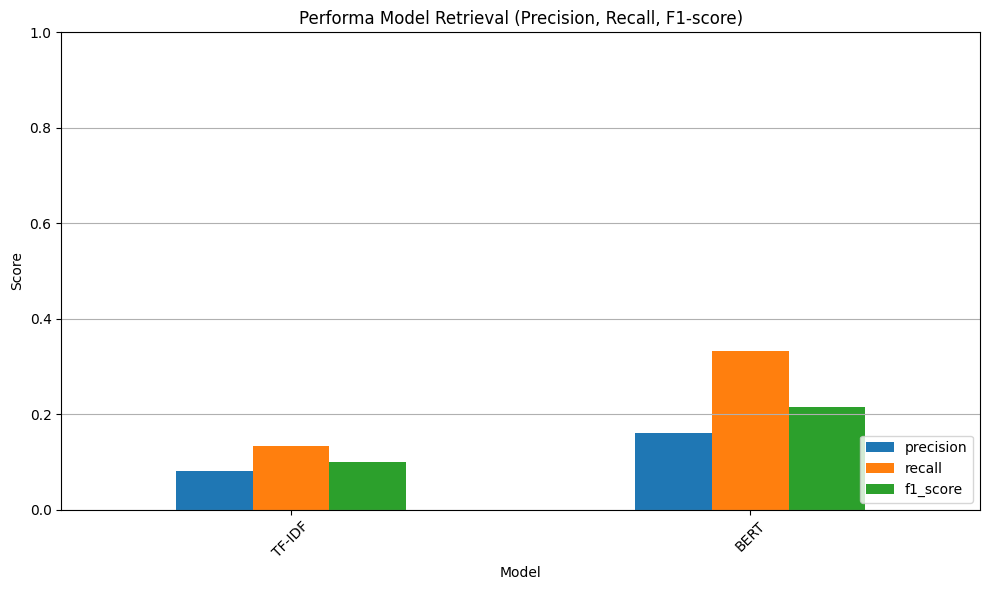


Tahap 5 (Model Evaluation) selesai.
Output evaluasi disimpan dan plot dihasilkan di folder 'data/eval'.


In [7]:
# --- SEL 5: Model Evaluation ---
# Pastikan Anda telah menjalankan semua sel sebelumnya.
import pandas as pd
import json
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Direktori yang sudah disiapkan di SEL 0.1
PROCESSED_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
EVAL_DIR = os.path.join(PROJECT_DIR, 'data', 'eval')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data', 'results')

# Muat data yang dibutuhkan
df_cases = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'cases.csv'))
with open(os.path.join(EVAL_DIR, 'queries.json'), 'r', encoding='utf-8') as f:
    queries_for_eval = json.load(f)

# Fungsi Evaluasi Retrieval
def eval_retrieval(queries, df_cases, vectorizer_tfidf=None, tfidf_matrix=None,
                   retrieval_type='tfidf', k=5, tokenizer_bert=None, model_bert=None, bert_embeddings=None):
    all_precision = []
    all_recall = []
    all_f1 = []

    for q_data in queries:
        query_text = q_data['query_text']
        ground_truth_ids = set(q_data['ground_truth_case_id'])

        # Lakukan retrieval
        retrieved_ids, _ = retrieve( # Panggil fungsi retrieve yang sudah didefinisikan sebelumnya
            query_text, k=k, df_cases=df_cases, vectorizer_tfidf=vectorizer_tfidf, tfidf_matrix=tfidf_matrix,
            retrieval_type=retrieval_type, tokenizer_bert=tokenizer_bert, model_bert=model_bert, bert_embeddings=bert_embeddings
        )
        retrieved_ids_set = set(retrieved_ids)

        # Hitung metrik (Precision, Recall, F1-score)
        true_positives = len(ground_truth_ids.intersection(retrieved_ids_set))
        false_positives = len(retrieved_ids_set - ground_truth_ids)
        false_negatives = len(ground_truth_ids - retrieved_ids_set) # Koreksi dari sebelumnya

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)

    avg_precision = np.mean(all_precision)
    avg_recall = np.mean(all_recall)
    avg_f1 = np.mean(all_f1)

    return {"precision": avg_precision, "recall": avg_recall, "f1_score": avg_f1}

print("--- Evaluasi Retrieval ---")

metrics_to_save = []

# Evaluasi TF-IDF
retrieval_metrics_tfidf = eval_retrieval(
    queries_for_eval, df_cases, vectorizer_tfidf=vectorizer_tfidf, tfidf_matrix=tfidf_matrix,
    retrieval_type='tfidf', k=5
)
print(f"\nTF-IDF Retrieval Metrics (k=5):")
for metric, value in retrieval_metrics_tfidf.items():
    print(f"  {metric.replace('_', ' ').capitalize()}: {value:.4f}")
metrics_to_save.append({'Model': 'TF-IDF', **retrieval_metrics_tfidf})

# Evaluasi BERT (jika berhasil diinisialisasi)
# Cek apakah variabel BERT global ada dan tidak None
if 'bert_embeddings' in globals() and bert_embeddings is not None:
    retrieval_metrics_bert = eval_retrieval(
        queries_for_eval, df_cases, retrieval_type='bert', k=5,
        tokenizer_bert=tokenizer_bert, model_bert=model_bert, bert_embeddings=bert_embeddings
    )
    print(f"\nBERT Retrieval Metrics (k=5):")
    for metric, value in retrieval_metrics_bert.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {value:.4f}")
    metrics_to_save.append({'Model': 'BERT', **retrieval_metrics_bert})

# Simpan hasil evaluasi retrieval
pd.DataFrame(metrics_to_save).to_csv(os.path.join(EVAL_DIR, 'retrieval_metrics.csv'), index=False)
print(f"\nRetrieval metrics saved to {EVAL_DIR}/retrieval_metrics.csv")

# Visualisasi Bar Chart Performa
metrics_df_plot = pd.DataFrame(metrics_to_save).set_index('Model')
if not metrics_df_plot.empty:
    metrics_df_plot[['precision', 'recall', 'f1_score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Performa Model Retrieval (Precision, Recall, F1-score)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(EVAL_DIR, 'retrieval_performance_bar_chart.png'))
    plt.show()
else:
    print("Tidak ada metrik untuk divisualisasikan.")

print("\nTahap 5 (Model Evaluation) selesai.")
print("Output evaluasi disimpan dan plot dihasilkan di folder 'data/eval'.")